In [55]:
import numpy as np  # probably don't need to load
import pandas as pd
import datetime as dt
#import pandas_datareader.data as web  # probably don't need to load
#import quandl

#import blpapi
#from xbbg import blp

#import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [10]:
path = 'Z:/Shared/Risk Management and Investment Technology/CLO Optimization/'
file = 'CLO21 model portfolio as of 03.18.21 - With New WARF Logic.xlsm'
filepath= path+file


# Functions

## Key Stat Functions

### Constraints/Tests

- [x] WARF test
- [x] diversity test
- [ ] Over-Collateralization test 
- [x] par burn/build
- [ ] Interest Coverage Ratio: Ratio of total interest income generated by the underlying pool of assets to the total interest due on the debt (tranches) outstanding.
- [ ] weighted average life test - S&P Weighted Average Life”: On any date of determination, a number calculated 
    by determining the number of years between the current date and the maturity date of each USActive 55321025.6 S-8-3 
    Collateral Obligation (with an S&P Rating of “CCC-” or higher), multiplying each Collateral 
    Obligation’s principal balance by its number of years, summing the results of all Collateral 
    Obligations in the portfolio, and dividing such amount by the aggregate principal balance of all 
    Collateral Obligations (with an S&P Rating of “CCC-” or higher). 
- [x] recovery rate test
- [x] CCC percentage

- security level attributes

- [x] spread
- [x] (WA)rf
- [x] market price / purchase if own it
- [x] maturity
- [x] rating


- [x] calculate the marginal diversity


In [243]:
# this works; spot checked
def moodys_adjusted_warf(df,moodys_score,moodys_rfTable):
    """
    This function creates the new Moody's Ratings Factor based 
    on the old Moody's rating.
    
    Arg in:
        df: the input data frame (from the MASTER table d/l'd from BMS)
        moodys_score: dataframe with alphanumeric rating to numeric map (1 to 1 map; linear)
        moodys_rfTable: dataframe with alphanumeric rating to new WARF numeric (1 to 1 map; 1 to 1000 values)
    """
    score = df['Moodys CFR'].map(dict(moodys_score[['Moodys','Score']].values))
    updown = df['Moodys Issuer Watch'].\
        apply(lambda x: -1 if x == 'Possible Upgrade' else 1 if x == 'Possible Downgrade' else 0)
    aScore = score + updown
    Adjusted_CFR_for_WARF = aScore.map(dict(moodys_score[['Score','Moodys']].values))
    # I keep the same column name as Jeff to make it easier to double check values
    df['Adj. WARF NEW'] = Adjusted_CFR_for_WARF.map(dict(moodys_rfTable[['Moody\'s Rating Factor Table','Unnamed: 10']].values))
    return df

def sp_recovery_rate(model_df,lien,new_rr,bond_table):
    """
    This function get the S&P recovery rate as a percent. If it doesn't exist
    in the master field, it will look up in the appropriate first and second 
    lien tables, if not, will look up the bond table.
    
    Arg in:
        model_df: the input data frame (from the MASTER table d/l'd from BMS)
        lien: a DF table with the RR's for first and second lien by country
        new_rr: a df mapping of the old notation for RR to a new RR in percentage
        bond_table: split out of a table for RR for bonds
    Arg out:
        model_df with inserted new column 'S&P Recovery Rate (AAA)'
    """
     
    # if it the Recovery rate exists lookup in AAA table
    model_df['S&P Recovery Rate (AAA)'] = model_df['S&P Recovery'].\
        map(dict(new_rr[['S&P Recovery Rating\nand Recovery\nIndicator of\nCollateral Obligations','“AAA”']].values))
    
    # doesn't exist, but first lien, use first lien table
    model_df.loc[pd.isna(model_df['S&P Recovery']) & (model_df['Lien Type']== 'First Lien'),'S&P Recovery Rate (AAA)'] =\
        model_df.loc[pd.isna(model_df['S&P Recovery']) & (model_df['Lien Type']== 'First Lien'),'Issuer Country'].\
        map(dict(lien[['Country Abv','RR']].values))
    
    
    # doesn't exist, but 2nd lien, use 2nd lien table
    model_df.loc[pd.isna(model_df['S&P Recovery']) & (model_df['Lien Type']== 'Second Lien'),'S&P Recovery Rate (AAA)'] = \
        model_df.loc[pd.isna(model_df['S&P Recovery']) & (model_df['Lien Type']== 'Second Lien'),'Issuer Country'].\
        map(dict(lien[['Country Abv','RR.2nd']].values))
    
    # the bonds
    model_df.loc[pd.isna(model_df['S&P Recovery']) & pd.isna(model_df['Lien Type']),'S&P Recovery Rate (AAA)'] = \
        model_df.loc[pd.isna(model_df['S&P Recovery']) & pd.isna(model_df['Lien Type']),'Issuer Country'].\
        map(dict(bond_table[['Country Abv.1','RR.1']].values))

    return model_df

def diversity_score(model_df, ind_avg_eu):
    """
    This function calculates the Moody's Industry Diversity Score for the CLO
    
    Arg in:
        model_df: the input data frame (from the MASTER table d/l'd from BMS)
        ind_avg_eu: Moody's discrete lookup table that maps AIEUS to IDS, need to be sorted
    Arg out:
        dscore: the scalar measure of the IDS
    """
    
    #first create the Par amount filtering out defaults
    #model_df['Par_no_default'] = model_df['Total']
    #model_df.loc[model_df['Default']=='Y','Par_no_default'] = 0
    div_df = model_df[['Parent Company','Moodys Industry','Par_no_default']].copy()
    div_df.sort_values(by='Moodys Industry',inplace=True)

    # this keeps the industry, but groups on parent company for multiple loans
    test = div_df.groupby(by=['Parent Company','Moodys Industry']).sum()
    avg_par_amt = test.sum()/test.count()   
    
    # create the EU score for each parent
    # Lesser of 1 and Issuer Par Amount for such issuer divided by the Average Par Amount.
    test['EU'] = test[['Par_no_default']]/test[['Par_no_default']].mean()
    test.loc[test['EU']>1,'EU']=1
    
    # groupby Industry for the Ind Div Score
    IDS = test.groupby(by=['Moodys Industry']).sum()

    # this is like vlookup(..,TRUE) where the nearest match on merge is used, direction controls how
    # backward is the lesser if EU falls between AIEUS marks
    df_merged = pd.merge_asof(IDS.sort_values('EU'), ind_avg_eu, left_on='EU', 
                          right_on='Aggregate\nIndustry\nEquivalent\nUnit Score', direction='backward', suffixes=['', '_2'])
    dscore = df_merged['Industry\nDiversity\nScore'].sum()
    return dscore

def weighted_average(model_df,cols):
    """
    Calculates the weighted average variable
    Args in:
        model_df
        cols: must be a list of two elements with the first element
        the weighting elements and the second the statistic to be weighted
    Arg out: 
        wa: scalar
    """
    #wa = model_df[cols].apply(lambda x: (x[0]*x[1]).sum()/x[0].sum())
    wa = (model_df[cols[0]]*model_df[cols[1]]).sum()/model_df[cols[0]].sum()
    return wa

def percentage_C(model_df):  
    perC = model_df.loc[model_df['Adjusted CFR for WARF'].str.match('C'),['Total']].sum()/model_df[['Total']].sum()
    return perC.values[0]

def percentage_SecondLien(model_df):  
    perC = model_df.loc[model_df['Lien Type']=='Second Lien',['Total']].sum()/model_df[['Total']].sum()
    return perC.values[0]

def percentage_SubEighty(model_df):  
    perC = model_df.loc[model_df['Blended Price']<80,['Total']].sum()/model_df[['Total']].sum()
    return perC.values[0]

def percentage_SubNinety(model_df):  
    perC = model_df.loc[model_df['Blended Price']<90,['Total']].sum()/model_df[['Total']].sum()
    return perC.values[0]

def percentage_CovLite(model_df):  
    perC = model_df.loc[model_df['Cov Lite']=='Yes',['Total']].sum()/model_df[['Total']].sum()
    return perC.values[0]


In [202]:
def BAPP(model_df):
    model_df['Blended Actual Purchase Prices'] = \
        model_df[['Addtl Purchase Amt','Purch Price of Addtl Purch',
                    'Current Portfolio','Actual Purch Price of Current Positions']].\
        apply(lambda x: 100*((x[0]*x[1]/100)+(x[2]*x[3]/100))/(x[0]+x[2]),axis=1)
    model_df.loc[model_df['Blended Actual Purchase Prices'].isna(),'Blended Actual Purchase Prices'] = 0
    return model_df

def blended_price(model_df):
    model_df['Blended Price'] = model_df[['Potential Trades',
            'Addtl Purchase Amt','Blended Actual Purchase Prices','Total','Bid','Ask','Current Portfolio']].\
            apply(lambda x: ((x[0]*x[4]/100+(x[6]+x[1])*x[2])/x[3])*100 if x[0]<1 else \
                            ((x[0]*x[5]/100+(x[6]+x[1])*x[2])/x[3])*100,axis=1 )
    model_df.loc[model_df['Blended Price'].isna(),'Blended Price'] = 0
    return model_df

def par_build_loss(model_df,pot_trades='Potential Trades'):
    model_df['Par_Build_Loss_Sale'] = model_df[[pot_trades,
                                                    'Bid','Actual Purch Price of Current Positions']].\
            apply(lambda x: ((-x[0]*x[1]/100)-(-x[0]*x[2]/100) if x[0]<0 else 0),axis=1)
    model_df['Par_Build_Loss_Buy'] = model_df[[pot_trades,'Ask']].\
            apply(lambda x: ((-x[0]*x[1]/100)+x[0]) if x[0]>0 else 0,axis=1)
    model_df['Total_Par_Build_Loss'] = model_df[['Par_Build_Loss_Sale','Par_Build_Loss_Buy']].sum(axis=1)
    return model_df



### Possible Liquidity Measures
- Equity like measures of liquidity (Low Freq-daily)
- Corwin and Schultz (Journal of Finance 2012) high-low ratio, daily
- Hasbrouck (Journal of Finance 2009)  Gibbs estimator
- Roll (Journal of Finance 1984) covariance spread

- Trader's scores we discussed

Notes:
- liquidity  everything gets a 1 for now  buy score, and sell score 
- internal rating we have this
- upside/downside ratio = f(recovery)  - 2nd order

e.g.
1000 in universe

250 that trade every day (1,1)
200 that they 1 once a week  (2,2)
never see  (5,5)

lon xyz use to (5,2)

### Marginal Statistics

In [222]:
def mil_par_build_loss(model_df,pot_trade_size=1000000):
    """
    This function calculates the Par B/L Sale, Buy and Total for ALL
    loans assuming 1mn notional (optional change size).  Essentially,
    consider this akin to Marginal Contribution to Par B/L
    
    Arg in:
        model_df
        pot_trade_size (default=100000)
    Arg out:
        model_df with additional columns, Mil_Par_BL_Sale, Mil_Par_BL_Buy, Mil_Par_Build_Loss
    """
    # you can buy anything but you can only sell what you own!
    trade = -pot_trade_size
    model_df['Mil_Par_BL_Sale'] = model_df.loc[model_port['Current Portfolio']>0,['Bid','Actual Purch Price of Current Positions']].\
            apply(lambda x: ((-trade*x[0]/100)-(-trade*x[1])),axis=1)  # I think this is wrong in xls
    trade = pot_trade_size
    model_df['Mil_Par_BL_Buy'] = model_df[['Ask']].\
            apply(lambda x: ((-trade*x/100)+trade),axis=1)
    model_df['Mil_Par_Build_Loss'] = model_df[['Mil_Par_BL_Sale','Mil_Par_BL_Buy']].sum(axis=1)
    return model_df

def mc_WARF(model_df,pot_trade_size=1000000):
    oldWARF = weighted_average(model_df,cols=['Par_no_default','Adj. WARF NEW'])
    
    for row in model_df.index:
        div_df = model_df[['Par_no_default','Adj. WARF NEW']].copy()    
        div_df.loc[row,'Par_no_default'] += pot_trade_size
        model_df.loc[row,'MC WARF'] = weighted_average(div_df,cols=['Par_no_default','Adj. WARF NEW']) - oldWARF

    return model_df

def mc_WAS(model_df,pot_trade_size=1000000):
    oldWARF = weighted_average(model_df,cols=['Par_no_default','Spread'])
  
    for row in model_df.index:
        div_df = model_df[['Par_no_default','Spread']].copy()    
        div_df.loc[row,'Par_no_default'] += pot_trade_size
        model_df.loc[row,'MC WAS'] = weighted_average(div_df,cols=['Par_no_default','Spread']) - oldWARF

    return model_df

def mc_WAPP(model_df,pot_trade_size=1000000):
    oldWARF = weighted_average(model_df,cols=['Par_no_default','Ask'])

    for row in model_df.index:
        div_df = model_df[['Par_no_default','Ask']].copy()    
        div_df.loc[row,'Par_no_default'] += pot_trade_size
        model_df.loc[row,'MC WAPP'] = weighted_average(div_df,cols=['Par_no_default','Ask']) - oldWARF
    return model_df

def MC_diversity_score(model_df, ind_avg_eu, pot_trade_size=1000000):
    """
    This function calculates the Marginal Contribution Moody's Industry Diversity Score 
    for all loan given a potential trade size (default 1mn)
    
    Arg in:
        model_df: the input data frame (from the MASTER table d/l'd from BMS)
        ind_avg_eu: Moody's discrete lookup table that maps AIEUS to IDS, need to be sorted
        pot_trade_size
    Arg out:
        model_df: with added MC Div Score field
    """
    curr_DS = diversity_score(model_df, ind_avg_eu)
    for row in model_df.index:
        div_df = model_df[['Parent Company','Moodys Industry','Par_no_default']].copy()    
        div_df.loc[row,'Par_no_default'] += pot_trade_size
        model_df.loc[row,'MC Div Score'] = diversity_score(div_df, ind_avg_eu) - curr_DS
    
    return model_df


## Portfolio Stats and Replines

In [239]:


def Port_stats(model_df, ind_avg_eu):
    """
    Arg in:
        model_df
        ind_avg_eu: table (df) Moody's discrete lookup table that maps AIEUS to IDS
    
    - Estimated Libor
    - Minimum Floating Spread Test - Without Libor Floors
    - Minimum Floating Spread Test - WithLibor Floors (adj. All in Rate)
    - Maximum Moody's Rating Factor Test
    - Maximum Moody's Rating Factor Test (NEW WARF)
    - Maximum Moody's Rating Factor Test (Orig WARF)
    - Minimum Weighted Average Moody's Recovery Rate Test
    - Minimum Weighted Average S&P Recovery Rate Class A-1a
    - Moody's Diversity Test
    - WAP (Current Positions use Actual purchase price, all others use Ask price)
    - Total Portfolio Par (excluding Defaults)
    - Total Portfolio Par
    - Current Portfolio 
    
    
    """
    
    Port_stats_df = pd.DataFrame(np.nan,index=['Min Floating Spread Test - no Libor Floors',
        'Min Floating Spread Test - With Libor Floors',
        'Max Moodys Rating Factor Test (NEW WARF)',
        'Max Moodys Rating Factor Test (Orig WARF)',
        'Min Moodys Recovery Rate Test',
        'Min S&P Recovery Rate Class A-1a',
        'Moodys Diversity Test',
        'WAP',
        'Percent C',
        'Percent 2nd Lien',
        'Percent Sub80',
        'Percent Sub90',
        'Percent CovLite',
        'Pot Par B/L Sale',
        'Pot Par B/L Buy',
        'Pot Par B/L Total',
        'Total Portfolio Par (excl. Defaults)',
        'Total Portfolio Par',
        'Current Portfolio'],columns = ['Portfolio Stats'])

    
    Port_stats_df.loc['Min Floating Spread Test - no Libor Floors','Portfolio Stats'] = \
        weighted_average(model_df,cols=['Par_no_default','Spread'])*100
    Port_stats_df.loc['Min Floating Spread Test - no Libor Floors'] = \
        Port_stats_df.loc['Min Floating Spread Test - no Libor Floors'].apply('{:.2f}%'.format)
    
    Port_stats_df.loc['Min Floating Spread Test - With Libor Floors','Portfolio Stats'] = \
        weighted_average(model_df,cols=['Par_no_default','Adj. All in Rate'])*100
    Port_stats_df.loc['Min Floating Spread Test - With Libor Floors'] = \
        Port_stats_df.loc['Min Floating Spread Test - With Libor Floors'].apply('{:.2f}%'.format)
    
    Port_stats_df.loc['Max Moodys Rating Factor Test (NEW WARF)','Portfolio Stats'] = \
        weighted_average(model_df,cols=['Par_no_default','Adj. WARF NEW'])
    Port_stats_df.loc['Max Moodys Rating Factor Test (NEW WARF)'] = \
        Port_stats_df.loc['Max Moodys Rating Factor Test (NEW WARF)'].apply('{:.0f}'.format)
    
    Port_stats_df.loc['Max Moodys Rating Factor Test (Orig WARF)','Portfolio Stats'] = \
        weighted_average(model_df,cols=['Par_no_default','WARF'])
    Port_stats_df.loc['Max Moodys Rating Factor Test (Orig WARF)'] = \
        Port_stats_df.loc['Max Moodys Rating Factor Test (Orig WARF)'].apply('{:.0f}'.format)
    
    Port_stats_df.loc['Min Moodys Recovery Rate Test','Portfolio Stats'] = \
        weighted_average(model_df,cols=['Par_no_default','Moodys Recovery Rate'])*100    
    Port_stats_df.loc['Min Moodys Recovery Rate Test'] = \
        Port_stats_df.loc['Min Moodys Recovery Rate Test'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Min S&P Recovery Rate Class A-1a','Portfolio Stats'] = \
            weighted_average(model_df,cols=['Par_no_default','S&P Recovery Rate (AAA)'])*100
    Port_stats_df.loc['Min S&P Recovery Rate Class A-1a'] = \
        Port_stats_df.loc['Min S&P Recovery Rate Class A-1a'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Moodys Diversity Test','Portfolio Stats'] = diversity_score(model_df, ind_avg_eu)
    Port_stats_df.loc['Moodys Diversity Test'] = \
        Port_stats_df.loc['Moodys Diversity Test'].apply('{:.0f}'.format)
    
    Port_stats_df.loc['WAP','Portfolio Stats'] = \
        weighted_average(model_df,cols=['Total','Blended Price'])
#        sum(model_df['Total']*model_df['Blended Price']/sum(model_df['Total']))
    Port_stats_df.loc['WAP'] = \
        Port_stats_df.loc['WAP'].apply('${:.2f}'.format)
    
    Port_stats_df.loc['Percent C','Portfolio Stats'] = percentage_C(model_df)*100
    Port_stats_df.loc['Percent C'] = \
        Port_stats_df.loc['Percent C'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Percent 2nd Lien','Portfolio Stats'] = percentage_SecondLien(model_df)*100
    Port_stats_df.loc['Percent 2nd Lien'] = \
        Port_stats_df.loc['Percent 2nd Lien'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Percent Sub80','Portfolio Stats'] = percentage_SubEighty(model_df)*100
    Port_stats_df.loc['Percent Sub80'] = \
        Port_stats_df.loc['Percent Sub80'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Percent Sub90','Portfolio Stats'] = percentage_SubNinety(model_df)*100
    Port_stats_df.loc['Percent Sub90'] = \
        Port_stats_df.loc['Percent Sub90'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Percent CovLite','Portfolio Stats'] = percentage_CovLite(model_df)*100
    Port_stats_df.loc['Percent CovLite'] = \
        Port_stats_df.loc['Percent CovLite'].apply('{:.1f}%'.format)

    
     # 87  Par_Build_Loss_Sale                      497 non-null    float64       
     # 88  Par_Build_Loss_Buy                       497 non-null    float64       
     # 89  Total_Par_Build_Loss                     497 non-null    float64      
    Port_stats_df.loc['Pot Par B/L Sale','Portfolio Stats'] = model_df['Par_Build_Loss_Sale'].sum()
    Port_stats_df.loc['Pot Par B/L Sale'] = \
        Port_stats_df.loc['Pot Par B/L Sale'].apply('{:,.0f}'.format)    
    
    Port_stats_df.loc['Pot Par B/L Buy','Portfolio Stats'] = model_df['Par_Build_Loss_Buy'].sum()
    Port_stats_df.loc['Pot Par B/L Buy'] = \
        Port_stats_df.loc['Pot Par B/L Buy'].apply('{:,.0f}'.format)    
    
    Port_stats_df.loc['Pot Par B/L Total','Portfolio Stats'] = model_df['Total_Par_Build_Loss'].sum()
    Port_stats_df.loc['Pot Par B/L Total'] = \
        Port_stats_df.loc['Pot Par B/L Total'].apply('{:,.0f}'.format)    

    Port_stats_df.loc['Total Portfolio Par (excl. Defaults)','Portfolio Stats'] = model_df['Par_no_default'].sum()
    Port_stats_df.loc['Total Portfolio Par (excl. Defaults)'] = \
        Port_stats_df.loc['Total Portfolio Par (excl. Defaults)'].apply('{:,.0f}'.format)

    
    Port_stats_df.loc['Total Portfolio Par','Portfolio Stats'] = model_df['Total'].sum()
    Port_stats_df.loc['Total Portfolio Par'] = \
        Port_stats_df.loc['Total Portfolio Par'].apply('{:,.0f}'.format)
    
    # current portfolio is Quantity + Add'l Amount (manual) TBA later
    Port_stats_df.loc['Current Portfolio','Portfolio Stats'] = model_df[['Addtl Purchase Amt','Current Portfolio']].sum(axis=1).sum()
    Port_stats_df.loc['Current Portfolio'] = \
        Port_stats_df.loc['Current Portfolio'].apply('{:,.0f}'.format)
    
    return Port_stats_df

def comp_Port_stats(model_df, ind_avg_eu):
    
    mask = abs(model_port['Current Portfolio']) > 0
    cstats = Port_stats(model_port.loc[mask],ind_avg_eu)
    cstats.rename(columns={'Portfolio Stats':'Current Portfolio'},inplace=True)

    mask = abs(model_port['Potential Trades']) > 0
    pstats = Port_stats(model_port.loc[mask],ind_avg_eu)
    pstats.rename(columns={'Portfolio Stats':'Potential Trades (incl Replines)'},inplace=True)
    
    tstats = Port_stats(model_port,ind_avg_eu)
    tstats.rename(columns={'Portfolio Stats':'Total Portfolio (incl Trades)'},inplace=True)
    
    cstats = cstats.join(pstats)
    cstats = cstats.join(tstats)
    
    return cstats

In [76]:
def replines(model_df):
    replines = model_df[model_df['Issuer'].str.match('zz_LXREP')]
    repline_stats_df = pd.DataFrame(np.nan,index=['Amount',
        'WAS',
        'WAPP',
        'WARF New',
        'WARF Orig'],columns = ['Repline Stats'])
    pot_trades = replines['Potential Trades']
    repline_stats_df.loc['Amount','Repline Stats'] = pot_trades.sum()/1000000
    repline_stats_df.loc['WAS','Repline Stats'] = (pot_trades*replines['Spread']).sum()/pot_trades.sum()*100
    repline_stats_df.loc['WAPP','Repline Stats'] = (pot_trades*replines['Ask']).sum()/pot_trades.sum()
    repline_stats_df.loc['WARF New','Repline Stats'] = (pot_trades*replines['Adj. WARF NEW']).sum()/pot_trades.sum()
    repline_stats_df.loc['WARF Orig','Repline Stats'] = (pot_trades*replines['WARF']).sum()/pot_trades.sum()
    
    # just formatting
    repline_stats_df.loc['Amount'] = repline_stats_df.loc['Amount'].apply('${:.1f}'.format)
    repline_stats_df.loc['WAS'] = repline_stats_df.loc['WAS'].apply('{:.2f}%'.format)
    repline_stats_df.loc['WAPP'] = repline_stats_df.loc['WAPP'].apply('{:.2f}'.format)
    repline_stats_df.loc['WARF New'] = repline_stats_df.loc['WARF New'].apply('{:.0f}'.format)
    repline_stats_df.loc['WARF Orig'] = repline_stats_df.loc['WARF Orig'].apply('{:.0f}'.format)
    
    return repline_stats_df


## Simple IO Functions for reading tables from Excel

In [77]:
# functions for reading the relevant spreadsheet data
# I am making them simple and separated so they can be replaced
# by other bespoke solutions like direct APIs from the source,
# also aides readability and debugging

def get_master_df(filepath,sheet='MASTER'):
    master_df = pd.read_excel(filepath,sheet_name=sheet,header=1)
    master_df = master_df.loc[:,~master_df.columns.str.match("Unnamed")]
    master_df.rename(columns={'LoanX ID':'LXID'},inplace=True)
    master_df.set_index('LXID', inplace=True)
    return master_df

def get_CLO_df(filepath,sheet='CLO 21 Port as of 3.18'):
    CLO_df = pd.read_excel(filepath,sheet_name=sheet,header=6,usecols='A:K')
    CLO_df.dropna(inplace=True)
    CLO_df.rename(columns={'Cusip or LIN':'LXID'},inplace=True)
    CLO_df.set_index('LXID', inplace=True)
    
    # these comments are here, because this is what I used to check
    # his pivot table columns M:0
    # CLO_df[['Cusip or LIN','Quantity','/Unit']].sort_values(by='.Cusip or LIN')
    # CLO_df[['Quantity']].sum()  # verified sum of Quantity
    # CLO_df[['/Unit']].mean()    # verified for average /Unit
    return CLO_df

def get_bidask_df(filepath,sheet='Bid.Ask 3.18'):
    bidask_df = pd.read_excel(filepath,sheet_name=sheet,header=0)
    bidask_df = bidask_df.loc[:,~bidask_df.columns.str.match("Unnamed")]
    bidask_df.set_index('LXID', inplace=True)
    return bidask_df

def get_moodys_rating2rf_tables(filepath,sheet='New WARF'):
    moodys_score = pd.read_excel(filepath,sheet_name=sheet,header=0,usecols='E:F')
    moodys_rfTable = pd.read_excel(filepath,sheet_name=sheet,header=0,usecols='J:K')
    return moodys_score, moodys_rfTable

def get_recovery_rate_tables(filepath,sheet='SP RR Updated'):
    new_sp_rr = pd.read_excel(filepath, sheet_name=sheet, header=1, usecols='L:M')
    new_sp_rr.dropna(how='all',inplace=True)

    lien_rr = pd.read_excel(filepath, sheet_name=sheet, header=1, usecols='A:I')
    lien_rr.dropna(how='all',inplace=True)

    bond_split = lien_rr[lien_rr['Country.1']=='Bonds'].index.values[0]
    bond_table = lien_rr.loc[bond_split+1:]
    lien_rr = lien_rr.loc[:bond_split-1]
    lien_rr.drop(columns=['Unnamed: 4','Country Abv.1','Country.1','Group.1'],inplace=True)
    lien_rr.rename(columns={'RR.1':'RR.2nd'},inplace=True)
    
    return new_sp_rr, lien_rr, bond_table

def get_ind_avg_eu_table(filepath,sheet='Diversity'):
    ind_avg_eu = pd.read_excel(filepath, sheet_name=sheet, header=8, usecols='K:L')
    ind_avg_eu.dropna(how='all',inplace=True)
    return ind_avg_eu

def get_pot_trades(filepath,sheet='Model Portfolio'):
    pot_trades = pd.read_excel(filepath,sheet_name=sheet,header=16,usecols='C:G')
    pot_trades.rename(columns={'LX ID':'LXID'},inplace=True)
    pot_trades.set_index('LXID', inplace=True)

    return pot_trades

## Function for adding in Pricing Fields
(need to expound to all posible purchases)
- now with the functions split out, let's add fields for all in the sub-functions

In [149]:
   
def model_pricing(model_df):
    model_df.loc[model_df['Close Offer'].isna(),'Close Offer'] = 99
    model_df.loc[model_df['Issuer'].str.match('zz_LXREP'),'Close Offer'] = 99.5
    model_df.loc[model_df['Issuer'].str.match('zz_LXREP03'),'Close Offer'] = 99
    model_df.loc[model_df['Issuer'].str.match('zz_LXREP12'),'Close Offer'] = 99
    model_df.loc[model_df['Close Bid'].isna(),'Close Bid'] = 99
    model_df.loc[model_df['/Unit'].isna(),'/Unit'] = 0
    model_df.rename(columns={'Close Offer':'Ask','Close Bid':'Bid',
                               '/Unit':'Actual Purch Price of Current Positions'},inplace=True)
    model_df.loc[model_df['Actual Purch Price of Current Positions'].isna(),'Actual Purch Price of Current Positions'] = 0
    model_df['Current Portfolio'] = model_df['Quantity']
    model_df.loc[model_df['Current Portfolio'].isna(),'Current Portfolio'] = 0
    model_df.loc[model_df['Potential Trades'].isna(),
               'Potential Trades'] = 0
    model_df.loc[model_df['Addtl Purchase Amt'].isna(),'Addtl Purchase Amt'] = 0
    model_df.loc[model_df['Purch Price of Addtl Purch'].isna(),'Purch Price of Addtl Purch'] = 0

    model_df['Total'] = model_df[['Current Portfolio',
                                      'Addtl Purchase Amt',
                                      'Potential Trades']].sum(axis=1)
    model_df['Now'] = model_df[['Current Portfolio',
                                      'Addtl Purchase Amt']].sum(axis=1)
    
    #create the Blended Actual Purchase Price field
    model_df = BAPP(model_df)

    #create the Blended Price field
    model_df = blended_price(model_df)

    # create the Par Build and Loss fields
    model_df = par_build_loss(model_df)
    
    model_df['Par_no_default'] = model_df['Total'].values
    model_df.loc[model_df['Default']=='Y','Par_no_default'] = 0

    model_df['Par_no_default_now'] = model_df['Now'].values
    model_df.loc[model_df['Default']=='Y','Par_no_default_now'] = 0
    
    return model_df

## Main function for creating Model Portfolio dataframe

In [79]:
def create_model_port_df(filepath):
    
    # first read in all relevant tables from the CLO model sprdsht
    master_df = get_master_df(filepath,sheet='MASTER')
    CLO_df = get_CLO_df(filepath,sheet='CLO 21 Port as of 3.18')
    bidask_df = get_bidask_df(filepath,sheet='Bid.Ask 3.18')
    moodys_score, moodys_rfTable = get_moodys_rating2rf_tables(filepath,sheet='New WARF')
    new_sp_rr, lien_rr, bond_table = get_recovery_rate_tables(filepath,sheet='SP RR Updated')
    ind_avg_eu = get_ind_avg_eu_table(filepath,sheet='Diversity')
    pot_trades = get_pot_trades(filepath,sheet='Model Portfolio')
    
      
    # merge MASTER + CLO + Bid.Ask + Potential Trades
    model_port = master_df.merge(CLO_df,left_on="LXID",right_on="LXID",how='outer') 
    model_port = model_port.merge(bidask_df,left_on="LXID",right_on="LXID",how='left')
    model_port = model_port.merge(pot_trades, left_on='LXID', right_on='LXID',how='outer')
    model_port.columns = model_port.columns.str.replace('\'','')
    
    # Here is where I think I should add subsetting for needed fields & renaming
    to_rename = {'Potential Trades\nBuys as Positives\nSales as (Negative)':'Potential Trades',
                 'Floating Spread':'Spread',
                 'Floating Spread Floor':'Floor'}
    
    model_port.rename(columns=to_rename,inplace=True)
    
    # add in metric like New WARF, SP's RR, Par no Default, Adj All in Rate
    model_port = moodys_adjusted_warf(model_port,moodys_score,moodys_rfTable)
    model_port = sp_recovery_rate(model_port,lien_rr,new_sp_rr,bond_table)
    
    # need a way to pass LIBOR
    libor = 0.002
    model_port['Adj. All in Rate'] = model_port[['Spread','Floor']].\
        apply(lambda x: (x[0]+x[1]-libor) if (x[1]>libor) else x[0],axis=1 )
    
    #add in all the Pricing stats
    model_port = model_pricing(model_port)
    
    return model_port, ind_avg_eu

# Create Model Portfolio Dataframe

In [80]:
model_port, ind_avg_eu = create_model_port_df(filepath)


<ipython-input-78-4cc58d81c306>:5: RuntimeWarning: invalid value encountered in double_scalars
  apply(lambda x: 100*((x[0]*x[1]/100)+(x[2]*x[3]/100))/(x[0]+x[2]),axis=1)
<ipython-input-78-4cc58d81c306>:12: RuntimeWarning: invalid value encountered in double_scalars
  apply(lambda x: ((x[0]*x[4]/100+(x[6]+x[1])*x[2])/x[3])*100 if x[0]<1 else \


In [101]:
mask = abs(model_port['Potential Trades']) > 0
mask

LXID
LX190245        False
LX190219        False
LX182732        False
USC6900PAL34    False
LX183929         True
                ...  
LXREP22          True
LXREP23          True
LXREP24          True
LXREP25          True
LXREP26          True
Name: Potential Trades, Length: 497, dtype: bool

## Create Marginal Contribution Fields

In [223]:
model_port = mil_par_build_loss(model_port)
#model_port = mc_WARF(model_port,pot_trade_size=1000000)
#model_port = MC_diversity_score(model_port, ind_avg_eu, pot_trade_size=1000000)
#model_port = mc_WAS(model_port,pot_trade_size=1000000)
#model_port = mc_WAPP(model_port,pot_trade_size=1000000)

In [204]:
model_port[['MC WARF','MC WAS', 'MC WAPP', 'MC Div Score']].head(20)


,MC WARF,MC WAS,MC WAPP,MC Div Score
LXID,,,,
LX190245,1.904366,0.000086,0.006360,-0.0584
LX190219,1.904366,0.000011,0.001373,-0.0584
LX182732,-2.394886,-0.000051,-0.002368,-0.0584
USC6900PAL34,-2.394886,-0.000082,-0.001744,-0.0584
LX183929,-2.394886,-0.000039,-0.002233,-0.0584
LX175827,-0.015834,0.000005,0.002542,0.1666
LX193380,-0.015834,0.000036,0.007989,-0.0584
LX191328,1.904366,0.000042,0.003243,-0.0584
LX192318,1.904366,0.000030,0.002620,-0.0584


In [221]:
model_port.loc[model_port['Current Portfolio']>0,['Mil_Par_BL_Sale','Current Portfolio']]

,Mil_Par_BL_Sale,Current Portfolio
LXID,,
LX193380,1014410.0,2000000.00
LX185949,988499.0,1500000.00
LX192164,986053.0,2000000.00
LX190229,986923.0,1893788.46
LX173270,978958.0,2500000.00
...,...,...
LX175817,976635.0,1250000.00
LX191244,987011.0,854000.00
LX184508,989547.0,1695739.35


# Model Portfolio stats
- To potentially add:
- WAL (for test)
- Overcollateralization (for test)
- Interest Coverage Test

In [244]:
pstats = Port_stats(model_port,ind_avg_eu)
pstats

,Portfolio Stats
Min Floating Spread Test - no Libor Floors,3.31%
Min Floating Spread Test - With Libor Floors,3.56%
Max Moodys Rating Factor Test (NEW WARF),2726
Max Moodys Rating Factor Test (Orig WARF),2816
Min Moodys Recovery Rate Test,47.8%
Min S&P Recovery Rate Class A-1a,42.2%
Moodys Diversity Test,80
WAP,$99.70
Percent C,1.6%
Percent 2nd Lien,1.0%


In [245]:
comp_Port_stats(model_port, ind_avg_eu)

,Current Portfolio,Potential Trades (incl Replines),Total Portfolio (incl Trades)
Min Floating Spread Test - no Libor Floors,3.29%,3.34%,3.31%
Min Floating Spread Test - With Libor Floors,3.48%,3.67%,3.56%
Max Moodys Rating Factor Test (NEW WARF),2779,2658,2726
Max Moodys Rating Factor Test (Orig WARF),2901,2706,2816
Min Moodys Recovery Rate Test,48.0%,47.6%,47.8%
Min S&P Recovery Rate Class A-1a,41.1%,42.9%,42.2%
Moodys Diversity Test,57,44,80
WAP,$99.75,$99.67,$99.70
Percent C,2.7%,0.0%,1.6%
Percent 2nd Lien,0.4%,1.5%,1.0%


In [58]:
replines(model_port)

,Repline Stats
Amount,$79.2
WAS,3.80%
WAPP,99.46
WARF New,3022
WARF Orig,2954


# Exploratory Charts

In [160]:
# This is a killer trick!  Must remember!

condlist = [abs(model_port['Current Portfolio']) > 0,            
            abs(model_port['Potential Trades']) > 0]

choicelist = ['Current', 'Potential']
model_port['Categorical'] = np.select(condlist, choicelist, default='Outside')

## Pairplot of Key Stats

C:\Users\jknechtel\Miniconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


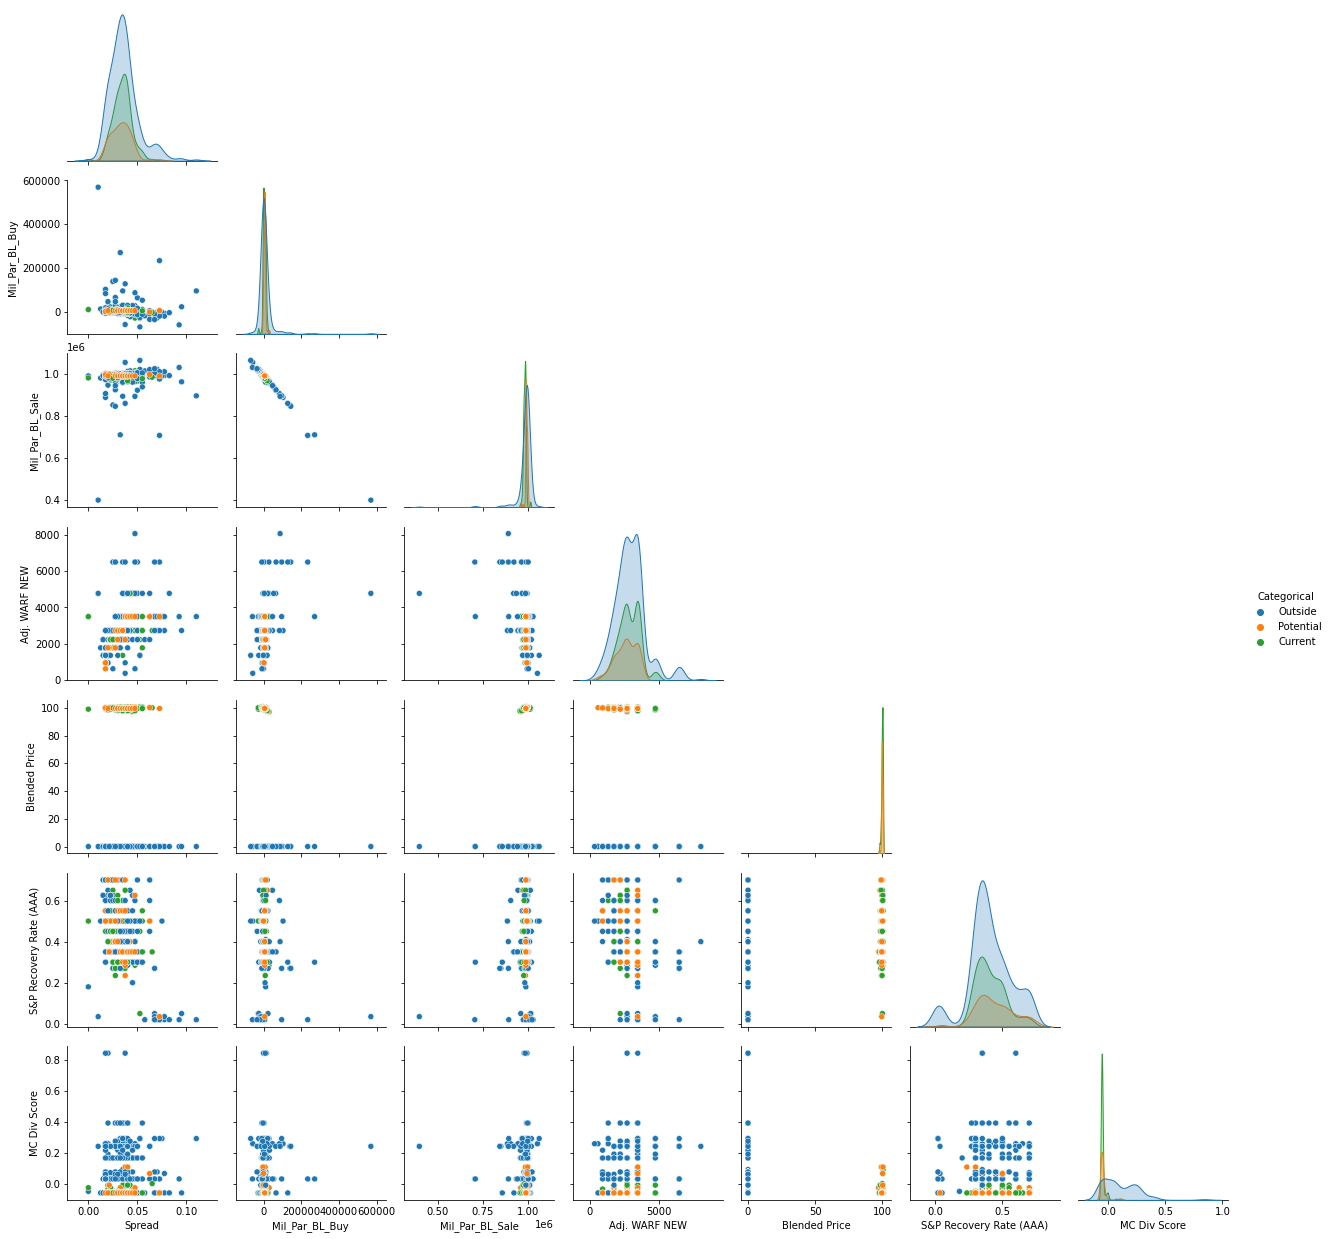

In [166]:
sns_plot = sns.pairplot(model_port[['Spread','Mil_Par_BL_Buy','Mil_Par_BL_Sale',
                                    'Adj. WARF NEW','Blended Price','S&P Recovery Rate (AAA)','MC Div Score','Categorical']],
                        diag_kind="kde",corner = True, hue='Categorical')  #, diag_kind='kde'
fig = sns_plot.fig
fig.savefig(path + "CLO_feature_PairPlot.png")

## Pairplot of Key Marginal Stats

C:\Users\jknechtel\Miniconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\jknechtel\Miniconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\jknechtel\Miniconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


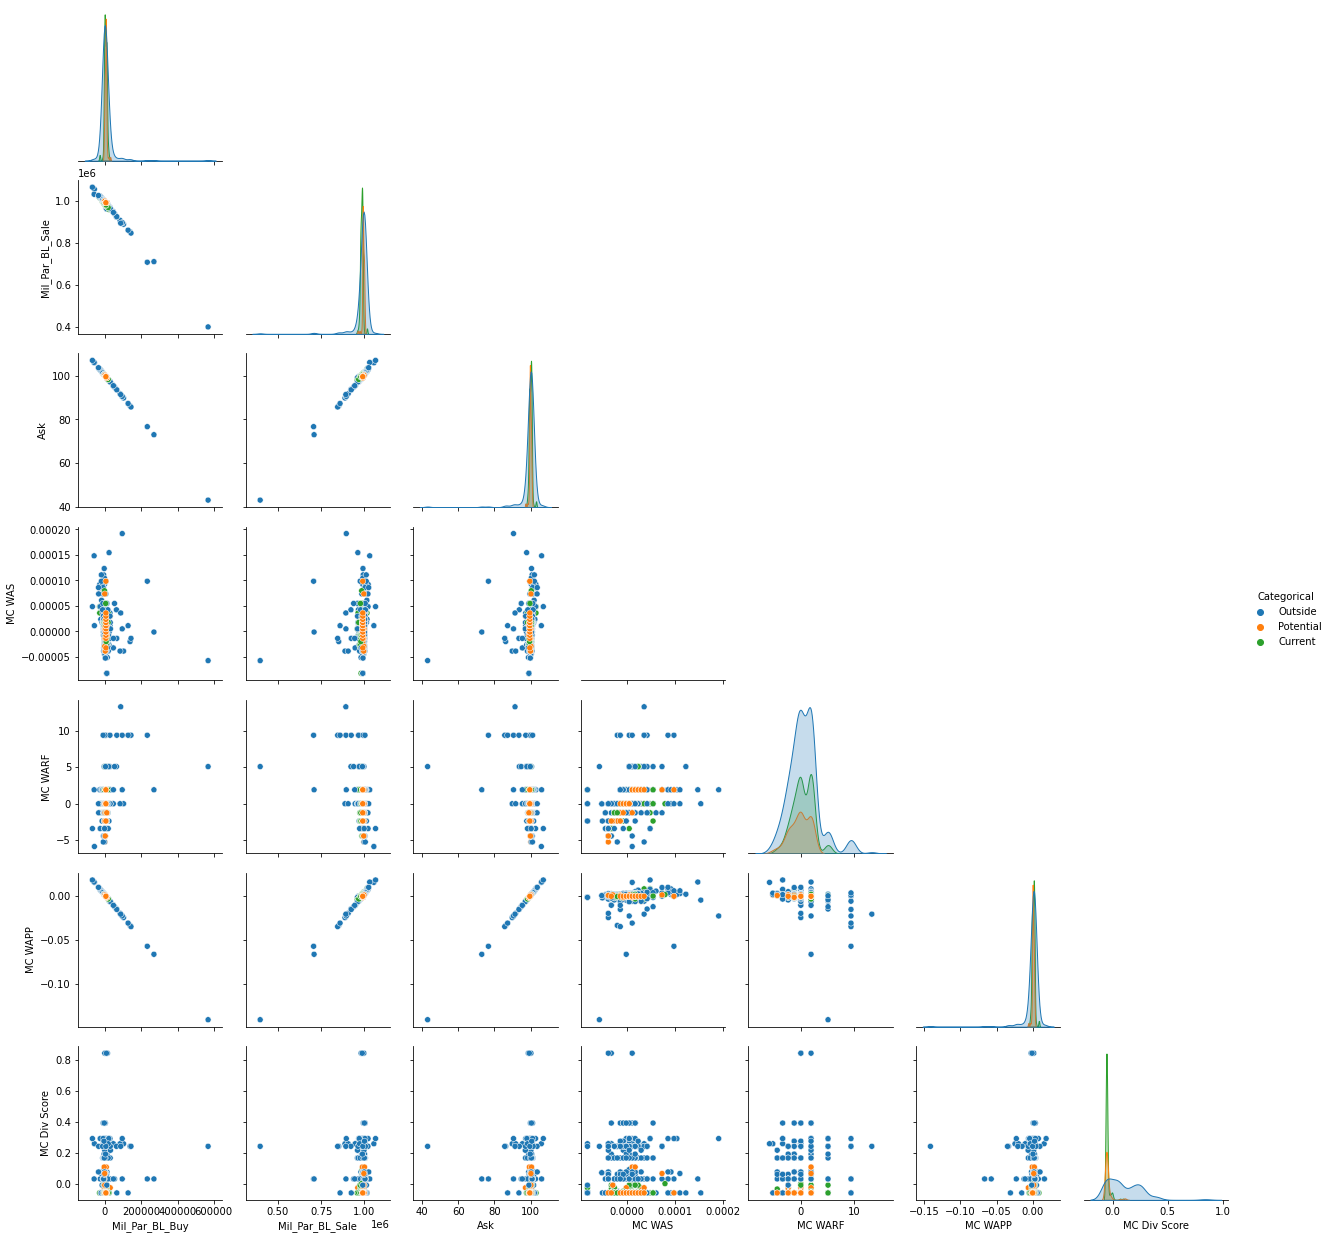

In [169]:
sns_plot = sns.pairplot(model_port[['Mil_Par_BL_Buy','Mil_Par_BL_Sale','Ask',
                                    'MC WAS','MC WARF','MC WAPP','MC Div Score','Categorical']], 
                        diag_kind="kde",corner = True,hue='Categorical')  #, diag_kind='kde'
fig = sns_plot.fig
fig.savefig(path + "CLO_Marginal_feature_PairPlot.png")

In [171]:
corr = model_port[['Spread','Mil_Par_BL_Buy','Mil_Par_BL_Sale','Ask',
                    'S&P Recovery Rate (AAA)','Adj. WARF NEW','Blended Price']].corr()
#pd.options.display.float_format = "{:,.2}".format
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Spread,Mil_Par_BL_Buy,Mil_Par_BL_Sale,Ask,S&P Recovery Rate (AAA),Adj. WARF NEW,Blended Price
Spread,1.00,-0.12,0.07,0.12,-0.52,0.43,-0.08
Mil_Par_BL_Buy,-0.12,1.00,-0.99,-1.00,-0.14,0.32,-0.07
Mil_Par_BL_Sale,0.07,-0.99,1.00,0.99,0.17,-0.35,0.00
Ask,0.12,-1.00,0.99,1.00,0.14,-0.32,0.07
S&P Recovery Rate (AAA),-0.52,-0.14,0.17,0.14,1.00,-0.37,0.06
Adj. WARF NEW,0.43,0.32,-0.35,-0.32,-0.37,1.00,-0.08
Blended Price,-0.08,-0.07,0.00,0.07,0.06,-0.08,1.00


# Screening

- goals = higher spread

types of queries?

- how do I raise my WAS by 5 bps and not burn more than 2mm in par

- how to I lower my WARF score without losing spread, or buring par, but willing to sacrifice other things?

- how can I raise my spread but not go above 3200 on WARF, or below 50 on diversity score?




In [72]:
# grab the current portfolio stats from above and create a splice where "spread"> current WAS

model_port[['Spread','Total_Par_Build_Loss','Adj. WARF NEW',
            'Parent Company','Moodys Industry','Par_no_default']].sort_values(by='Spread',ascending=False)

,Spread,Total_Par_Build_Loss,Adj. WARF NEW,Parent Company,Moodys Industry,Par_no_default
LXID,,,,,,
LX187441,0.1100,0.0,3490.0,"Constellis Holdings, LLC",Aerospace & Defense,0.0
LX169474,0.0950,0.0,2720.0,"Research Now Group, Inc.",Services: Business,0.0
LX192625,0.0925,0.0,3490.0,Dynacast (Form Technologies),Capital Equipment,0.0
LX181831,0.0825,0.0,4770.0,MyEyeDr,Retail Stores,0.0
LX191924,0.0775,0.0,3490.0,ICP Group Holdings,"Chemicals, Plastics, & Rubber",0.0
...,...,...,...,...,...,...
USU17185AG14,NaN,0.0,3490.0,CITGO Petroleum Corporation,Energy: Oil & Gas,0.0
USU2089PAE17,NaN,0.0,2720.0,"Consolidated Communications, Inc.",Telecommunications,0.0
USL2969BAA54,NaN,0.0,3490.0,Endo Pharmaceuticals,Healthcare & Pharmaceuticals,0.0


## E.g. 1, How do I raise my WAS by 5 bps and not burn more than 2mm in Par?

In [226]:
mask = (model_port['MC WAS']>0)&(model_port['Mil_Par_BL_Buy']>0)
model_port.loc[mask, ['Spread','MC WAS','Total_Par_Build_Loss','Adj. WARF NEW',
            'Parent Company','Moodys Industry','Mil_Par_BL_Buy']].sort_values(by='Spread',ascending=False)

,Spread,MC WAS,Total_Par_Build_Loss,Adj. WARF NEW,Parent Company,Moodys Industry,Mil_Par_BL_Buy
LXID,,,,,,,
LX187441,0.1100,0.000192,0.00000,3490.0,"Constellis Holdings, LLC",Aerospace & Defense,95000.0
LX169474,0.0950,0.000154,0.00000,2720.0,"Research Now Group, Inc.",Services: Business,22500.0
LXREP26,0.0725,0.000098,14583.31575,3490.0,LXREP26,Capital Equipment,5000.0
LX171490,0.0725,0.000098,0.00000,3490.0,EaglePicher,Aerospace & Defense,5000.0
LX171510,0.0725,0.000098,0.00000,6500.0,"AVSC Holding Corp. (aka PSAV, Inc.)",Services: Business,233330.0
...,...,...,...,...,...,...,...
LX191271,0.0350,0.000005,0.00000,3490.0,"Endurance International Group Holdings, Inc.",Services: Business,3440.0
LX188676,0.0350,0.000005,5000.00000,2720.0,Lummus Technology,Services: Business,10000.0
LX172702,0.0350,0.000005,0.00000,3490.0,Intrado Corporation,Telecommunications,22680.0


In [227]:
Port_stats(model_port.loc[mask],ind_avg_eu)

,Portfolio Stats
Min Floating Spread Test - no Libor Floors,4.10%
Min Floating Spread Test - With Libor Floors,4.49%
Max Moodys Rating Factor Test (NEW WARF),3372
Max Moodys Rating Factor Test (Orig WARF),3475
Min Moodys Recovery Rate Test,46.4%
Min S&P Recovery Rate Class A-1a,37.5%
Moodys Diversity Test,30
WAP,$99.34
Percent C,4.6%
Pot Par B/L Sale,0


## E.g. 2, How to I lower my WARF score without losing spread, or buring par, but willing to sacrifice other things?

In [207]:
model_port.loc[(model_port['MC WARF']<0)&(model_port['Mil_Par_BL_Buy']>0)&(model_port['MC WAS']>0),
               ['Spread','MC WAS','Total_Par_Build_Loss','Adj. WARF NEW',
            'Parent Company','Moodys Industry','Mil_Par_BL_Buy']].sort_values(by='Spread',ascending=False)

,Spread,MC WAS,Total_Par_Build_Loss,Adj. WARF NEW,Parent Company,Moodys Industry,Mil_Par_BL_Buy
LXID,,,,,,,
LX169474,0.095000,0.000154,0.0,2720.0,"Research Now Group, Inc.",Services: Business,22500.0
LX153523,0.055000,0.000055,0.0,2720.0,Pet Holdings ULC,Retail Stores,10000.0
LX153524,0.055000,0.000055,0.0,2720.0,Pet Holdings ULC,Retail Stores,10000.0
LX179530,0.050000,0.000042,0.0,2220.0,"Staples, Inc.",Services: Business,16190.0
LX192522,0.047500,0.000036,0.0,2720.0,Jadex Inc.,Consumer Goods: Non-durable,7500.0
LX155666,0.045000,0.000030,28750.0,2720.0,Augusta Sportswear,Consumer Goods: Non-durable,28750.0
LX179819,0.045000,0.000030,0.0,2220.0,"Staples, Inc.",Services: Business,4170.0
LX182786,0.037500,0.000011,6775.0,2720.0,Cumulus Media New Holdings Inc.,Media: Broadcasting & Subscription,2710.0
LX193157,0.037500,0.000011,0.0,2720.0,Ion Corporates,High Tech Industries,1870.0


## E.g. 3, How can I raise my spread but not go above 3200 on WARF, or below 50 on diversity score?

In [208]:
model_port.loc[(model_port['MC WAS']>0)&(model_port['Adj. WARF NEW']<3400)&(model_port['MC Div Score']>0),
               ['Spread','MC WAS','Total_Par_Build_Loss','Adj. WARF NEW',
            'Parent Company','Moodys Industry','Mil_Par_BL_Buy']].sort_values(by='Spread',ascending=False)

,Spread,MC WAS,Total_Par_Build_Loss,Adj. WARF NEW,Parent Company,Moodys Industry,Mil_Par_BL_Buy
LXID,,,,,,,
LX188807,0.0675,0.000086,0.0,2720.0,UKG Inc.,High Tech Industries,-35830.0
LX191236,0.0650,0.000080,0.0,2720.0,Syncapay,Services: Business,-2810.0
LX190612,0.0625,0.000073,0.0,2220.0,"MSG National Properties, LLC","Hotel, Gaming, & Leisure",-35000.0
LX153523,0.0550,0.000055,0.0,2720.0,Pet Holdings ULC,Retail Stores,10000.0
LX153524,0.0550,0.000055,0.0,2720.0,Pet Holdings ULC,Retail Stores,10000.0
LX188905,0.0525,0.000048,0.0,1350.0,"United AirLines, Inc.",Aerospace & Defense,-69380.0
LX188714,0.0525,0.000048,0.0,1350.0,JetBlue Airways Corporation,Aerospace & Defense,-26530.0
LX192269,0.0500,0.000042,0.0,2720.0,"Lew's Intermediate Holdings, LLC",Consumer Goods: Durable,-10000.0
LX183442,0.0500,0.000042,0.0,2220.0,Liberty Cablevision of Puerto Rico (aka LCPR),Media: Broadcasting & Subscription,-11000.0


## E.g. 4, How about potential Sells

In [225]:

model_port.loc[(model_port['MC WAS']<0)&(model_port['Mil_Par_BL_Sale']>0),
               ['Spread','MC WAS','Total_Par_Build_Loss','Adj. WARF NEW',
            'Parent Company','Moodys Industry','Mil_Par_BL_Sale']].sort_values(by='Spread',ascending=False)

,Spread,MC WAS,Total_Par_Build_Loss,Adj. WARF NEW,Parent Company,Moodys Industry,Mil_Par_BL_Sale
LXID,,,,,,,
LX171798,0.0325,-0.000001,0.0,3490.0,Mavis Tire Express Services Corp.,Consumer Goods: Durable,2690.0
LX170802,0.0300,-0.000008,0.0,3490.0,Prometric Holdings Inc. (fka ETS Holdings Inc.),Services: Business,2170.0
LX193398,0.0275,-0.000014,0.0,2220.0,"Granite Acquisition, Inc.",Utilities: Electric,3750.0
LX193103,0.0225,-0.000026,0.0,1766.0,Harsco Corporation,Environmental Industries,420.0
LX193330,0.0200,-0.000033,0.0,940.0,Avast Software B.V.,High Tech Industries,1250.0
LX192886,0.0200,-0.000033,0.0,1350.0,"Horizon Therapeutics USA, Inc.",Healthcare & Pharmaceuticals,1250.0


# Optimization 
( or Creating Baskets of Buys/Sales)

# Extra Stuff, Testing


In [30]:

# this has NaT's for some reason, also not likely what is used in WAL test
def WAL(model_df):  
    wal = (model_df['Par_no_default']*(model_df['Maturity']-pd.Timestamp.today())).sum()/model_df['Par_no_default'].sum()*100
    return wal

#def OC_test():
#    return

#def IC_test():
#    return

In [34]:
model_port[['Maturity']].info()
#model_port['Maturity']-pd.Timestamp.today()
WAL(model_port)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 0 to 496
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Maturity  456 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 23.9 KB


C:\Users\jknechtel\Miniconda3\lib\site-packages\pandas\core\arrays\timedeltas.py:507: RuntimeWarning: invalid value encountered in multiply
  result = self._data * other


Timedelta('0 days 00:00:00')

In [74]:
def blended_price_ex_trade(model_df):
    '''
    Blended Price without Potential Trades
    this is non-sense
    '''
    model_df['Blended Price ex Trades'] = model_df[['Potential Trades',
            'Addtl Purchase Amt','Blended Actual Purchase Prices','Total','Bid','Ask','Current Portfolio']].\
            apply(lambda x: (((x[6]+x[1])*x[2])/x[3])*100,axis=1 )
    model_df.loc[model_df['Blended Price ex Trades'].isna(),'Blended Price ex Trades'] = 0
    return model_df


In [85]:
def Port_stats_delta(model_df, ind_avg_eu):
    Port_stats_df = pd.DataFrame(np.nan,index=['Min Floating Spread Test - no Libor Floors',
        'Min Floating Spread Test - With Libor Floors',
        'Max Moodys Rating Factor Test (NEW WARF)',
        'Max Moodys Rating Factor Test (Orig WARF)',
        'Min Moodys Recovery Rate Test',
        'Min S&P Recovery Rate Class A-1a',
        'Moodys Diversity Test',
        'WAP',
        'Total Portfolio Par (excl. Defaults)',
        'Total Portfolio Par',
        'Current Portfolio'],columns = ['Portfolio Stats'])

    
    
    Port_stats_df.loc['Min Floating Spread Test - no Libor Floors','Portfolio Stats'] = \
        (model_df['Par_no_default_now']*model_df['Spread']).sum()/model_df['Par_no_default_now'].sum()*100
    Port_stats_df.loc['Min Floating Spread Test - no Libor Floors'] = \
        Port_stats_df.loc['Min Floating Spread Test - no Libor Floors'].apply('{:.2f}%'.format)
    
    Port_stats_df.loc['Min Floating Spread Test - With Libor Floors','Portfolio Stats'] = \
        (model_df['Par_no_default_now']*model_df['Adj. All in Rate']).sum()/model_df['Par_no_default_now'].sum()*100
    Port_stats_df.loc['Min Floating Spread Test - With Libor Floors'] = \
        Port_stats_df.loc['Min Floating Spread Test - With Libor Floors'].apply('{:.2f}%'.format)
    
    Port_stats_df.loc['Max Moodys Rating Factor Test (NEW WARF)','Portfolio Stats'] = \
        (model_df['Par_no_default_now']*model_df['Adj. WARF NEW']).sum()/model_df['Par_no_default_now'].sum()
    Port_stats_df.loc['Max Moodys Rating Factor Test (NEW WARF)'] = \
        Port_stats_df.loc['Max Moodys Rating Factor Test (NEW WARF)'].apply('{:.0f}'.format)
    
    Port_stats_df.loc['Max Moodys Rating Factor Test (Orig WARF)','Portfolio Stats'] = \
        (model_df['Par_no_default_now']*model_df['WARF']).sum()/model_df['Par_no_default_now'].sum()
    Port_stats_df.loc['Max Moodys Rating Factor Test (Orig WARF)'] = \
        Port_stats_df.loc['Max Moodys Rating Factor Test (Orig WARF)'].apply('{:.0f}'.format)
    
    Port_stats_df.loc['Min Moodys Recovery Rate Test','Portfolio Stats'] = \
        (model_df['Par_no_default_now']*model_df['Moodys Recovery Rate']).sum()/model_df['Par_no_default_now'].sum()*100
    Port_stats_df.loc['Min Moodys Recovery Rate Test'] = \
        Port_stats_df.loc['Min Moodys Recovery Rate Test'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Min S&P Recovery Rate Class A-1a','Portfolio Stats'] = \
        (model_df['Par_no_default_now']*model_df['S&P Recovery Rate (AAA)']).sum()/model_df['Par_no_default_now'].sum()*100
    Port_stats_df.loc['Min S&P Recovery Rate Class A-1a'] = \
        Port_stats_df.loc['Min S&P Recovery Rate Class A-1a'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Moodys Diversity Test','Portfolio Stats'] = diversity_score(model_df, ind_avg_eu)
    Port_stats_df.loc['Moodys Diversity Test'] = \
        Port_stats_df.loc['Moodys Diversity Test'].apply('{:.0f}'.format)
    
    model_df = blended_price_ex_trade(model_df)
    Port_stats_df.loc['WAP','Portfolio Stats'] = \
        sum(model_df['Now']*model_df['Blended Price ex Trades']/sum(model_df['Now']))
    Port_stats_df.loc['WAP'] = \
        Port_stats_df.loc['WAP'].apply('${:.2f}'.format)

    Port_stats_df.loc['Total Portfolio Par (excl. Defaults)','Portfolio Stats'] = model_df['Par_no_default_now'].sum()
    Port_stats_df.loc['Total Portfolio Par (excl. Defaults)'] = \
        Port_stats_df.loc['Total Portfolio Par (excl. Defaults)'].apply('{:,.0f}'.format)

    
    Port_stats_df.loc['Total Portfolio Par','Portfolio Stats'] = model_df['Now'].sum()
    Port_stats_df.loc['Total Portfolio Par'] = \
        Port_stats_df.loc['Total Portfolio Par'].apply('{:,.0f}'.format)
    
    # current portfolio is Quantity + Add'l Amount (manual) TBA later
    Port_stats_df.loc['Current Portfolio','Portfolio Stats'] = model_df[['Addtl Purchase Amt','Current Portfolio']].sum(axis=1).sum()
    Port_stats_df.loc['Current Portfolio'] = \
        Port_stats_df.loc['Current Portfolio'].apply('{:,.0f}'.format)
    
    return Port_stats_df

In [86]:
# this excludes the Potential Trades Column in all stats
# diversity isn't linked with Par no Default w/o Potential Trades (need mask)
# need to figure out a way to pass masks for comparison
# also add sum(Par B/L Total to the stats)
Port_stats_delta(model_port, ind_avg_eu)

<ipython-input-74-87227eab09ea>:8: RuntimeWarning: invalid value encountered in double_scalars
  apply(lambda x: (((x[6]+x[1])*x[2])/x[3])*100,axis=1 )


,Portfolio Stats
Min Floating Spread Test - no Libor Floors,3.28%
Min Floating Spread Test - With Libor Floors,3.47%
Max Moodys Rating Factor Test (NEW WARF),2785
Max Moodys Rating Factor Test (Orig WARF),2908
Min Moodys Recovery Rate Test,48.0%
Min S&P Recovery Rate Class A-1a,41.2%
Moodys Diversity Test,80
WAP,$97.72
Total Portfolio Par (excl. Defaults),"226,333,337"
Total Portfolio Par,"226,333,337"


In [154]:
model_port.info()

<class 'pandas.core.frame.DataFrame'>
Index: 497 entries, LX190245 to LXREP26
Data columns (total 100 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Combined                                 497 non-null    object        
 1   Parent Company                           497 non-null    object        
 2   Issuer                                   497 non-null    object        
 3   Asset                                    497 non-null    object        
 4   Analyst                                  463 non-null    object        
 5   Spread                                   489 non-null    float64       
 6   Floor                                    474 non-null    float64       
 7   All In Rate                              471 non-null    float64       
 8   Maturity Date                            495 non-null    datetime64[ns]
 9   Mark Price                          

In [234]:
def percentage_SubEighty(model_df):  
    perC = model_df.loc[model_df['Blended Price']<80,['Total']].sum()/model_df[['Total']].sum()
    return perC.values[0]

def percentage_SubNinety(model_df):  
    perC = model_df.loc[model_df['Blended Price']<90,['Total']].sum()/model_df[['Total']].sum()
    return perC.values[0]


percentage_SubNinety(model_port)*100

0.0

In [231]:
model_port.loc[model_port['Lien Type']=='Second Lien',['Total']]

,Total
LXID,
